## In v0.2, model was trained on all data.  This may be why model overestimates.  Retrain with data filtered for waittime values below threshold.

* Remove start/end from init()
* Add filtering after neighbors created in prepare_source()

In [4]:
from datetime import date, datetime
from BorderModel import BorderImpute
from sklearn.ensemble import ExtraTreesRegressor
from dbhelper import pd_query
import matplotlib.pyplot as plt
%matplotlib inline

imputer = BorderImpute(threshold=10, window=32)

# Get source data with neighbor features
source_query = '''
               select 
                   c.date,
                   year,
                   month,
                   dayofweek,
                   minofday,
                   metric as volume,
                   waittime
               from crossingdata c
               join datefeatures d
                   on d.date = c.date
               join mungedata m 
                   on m.date = c.date
                   and m.crossing_id = c.crossing_id
                   and munger_id = 2
                   and is_waittime = false
                   and metric is not null
               where
                   c.crossing_id=1
                   and valid = 1
                   and waittime is not null
                order by c.date;
               '''


In [5]:
from BorderModel import BorderImpute
dfsource = imputer.prepare_source(pd_query(source_query))
model = ExtraTreesRegressor(n_jobs=-1, n_estimators=100, bootstrap=True, oob_score=True)
imputer.build_model(model)

In [6]:
print imputer.model_ll.oob_score_
print imputer.model_lead.oob_score_
print imputer.model_lag.oob_score_

0.673683499312
0.649033986838
0.652925939552


In [7]:
target_query = '''
               select 
                   c.date,
                   year,
                   month,
                   dayofweek,
                   minofday,
                   metric as volume,
                   waittime
               from crossingdata c
               join datefeatures d
                   on d.date = c.date
               join mungedata m 
                   on m.date = c.date
                   and m.crossing_id = c.crossing_id
                   and munger_id = 2
                   and is_waittime = false
                   and metric is not null
               where
                   c.crossing_id=5
                   and valid = 1
                   and waittime is not null
                order by c.date;
               '''

target_df = pd_query(target_query)

In [9]:
from BorderModel import emulate_testdata

imputer.prepare_target(emulate_testdata(target_df)).head(20)

,year,month,dayofweek,minofday,volume,waittime,lead,lag
date,,,,,,,,
2007-01-01 00:05:00,2007,1,0,5,2.02127,NaN,17.951128,NaN
2007-01-01 00:10:00,2007,1,0,10,1.83179,NaN,17.908451,NaN
2007-01-01 00:15:00,2007,1,0,15,1.68238,NaN,17.864238,NaN
2007-01-01 00:20:00,2007,1,0,20,1.57438,NaN,17.487730,NaN
2007-01-01 00:25:00,2007,1,0,25,1.52900,NaN,17.447674,NaN
2007-01-01 00:30:00,2007,1,0,30,1.92317,NaN,17.414365,NaN
2007-01-01 00:35:00,2007,1,0,35,2.37534,NaN,17.333333,NaN
2007-01-01 00:40:00,2007,1,0,40,2.79511,NaN,17.826087,NaN
2007-01-01 00:45:00,2007,1,0,45,3.19051,NaN,18.087324,NaN


In [10]:
from BorderModel import BorderImpute
imputer.predict()

80537
6971
194
0


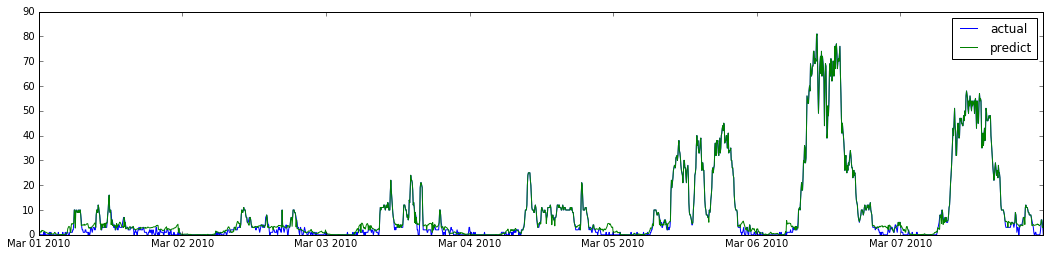

In [12]:
start = '2010-03-01'
end = '2010-03-08'
plt.figure(figsize=(18,4))
plt.plot(target_df[(target_df.date >= start) & (target_df.date < end)].set_index('date').waittime, label='actual')
plt.plot(imputer.predictdf[(imputer.predictdf.index >= start) & (imputer.predictdf.index < end)].waittime, label='predict')
plt.legend();

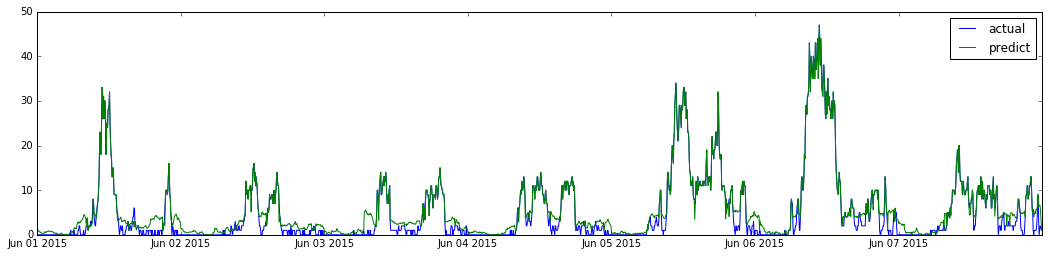

In [13]:
start = '2015-06-01'
end = '2015-06-08'
plt.figure(figsize=(18,4))
plt.plot(target_df[(target_df.date >= start) & (target_df.date < end)].set_index('date').waittime, label='actual')
plt.plot(imputer.predictdf[(imputer.predictdf.index >= start) & (imputer.predictdf.index < end)].waittime, label='predict')
plt.legend();

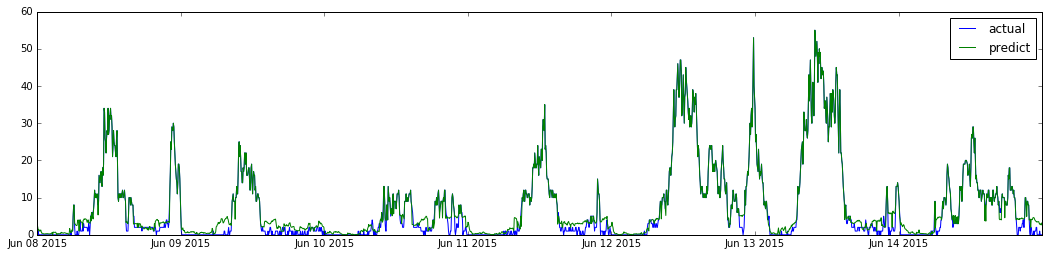

In [14]:
start = '2015-06-08'
end = '2015-06-015'
plt.figure(figsize=(18,4))
plt.plot(target_df[(target_df.date >= start) & (target_df.date < end)].set_index('date').waittime, label='actual')
plt.plot(imputer.predictdf[(imputer.predictdf.index >= start) & (imputer.predictdf.index < end)].waittime, label='predict')
plt.legend();

In [15]:
from sklearn.metrics import r2_score

r2_score(target_df.set_index('date')[pd.isnull(imputer.targetdf.waittime)].waittime,
         imputer.predictdf[pd.isnull(imputer.targetdf.waittime)].waittime)

-0.2604428483427963

In [16]:
def run_impute(threshold, window, source_query, target_query):
    imputer = BorderImpute(threshold=threshold, window=window)

    dfsource = imputer.prepare_source(pd_query(source_query))
    model = ExtraTreesRegressor(n_jobs=-1, n_estimators=100, bootstrap=True, oob_score=True)
    imputer.build_model(model)
    
    return r2_score(target_df.set_index('date')[pd.isnull(imputer.targetdf.waittime)].waittime,
                    imputer.predictdf[pd.isnull(imputer.targetdf.waittime)].waittime)

In [ ]:
import os
from ipyparallel import Client
rc = Client()
dview = rc[:]

# set proper working directory on all clients
cwd = os.getcwd()
dview.map(os.chdir, [cwd] * 40)
# print(dview.apply_sync(os.getcwd))

with dview.sync_imports():
    import datetime
    from BorderModel import BorderImpute